Successfully loaded and processed performance data.


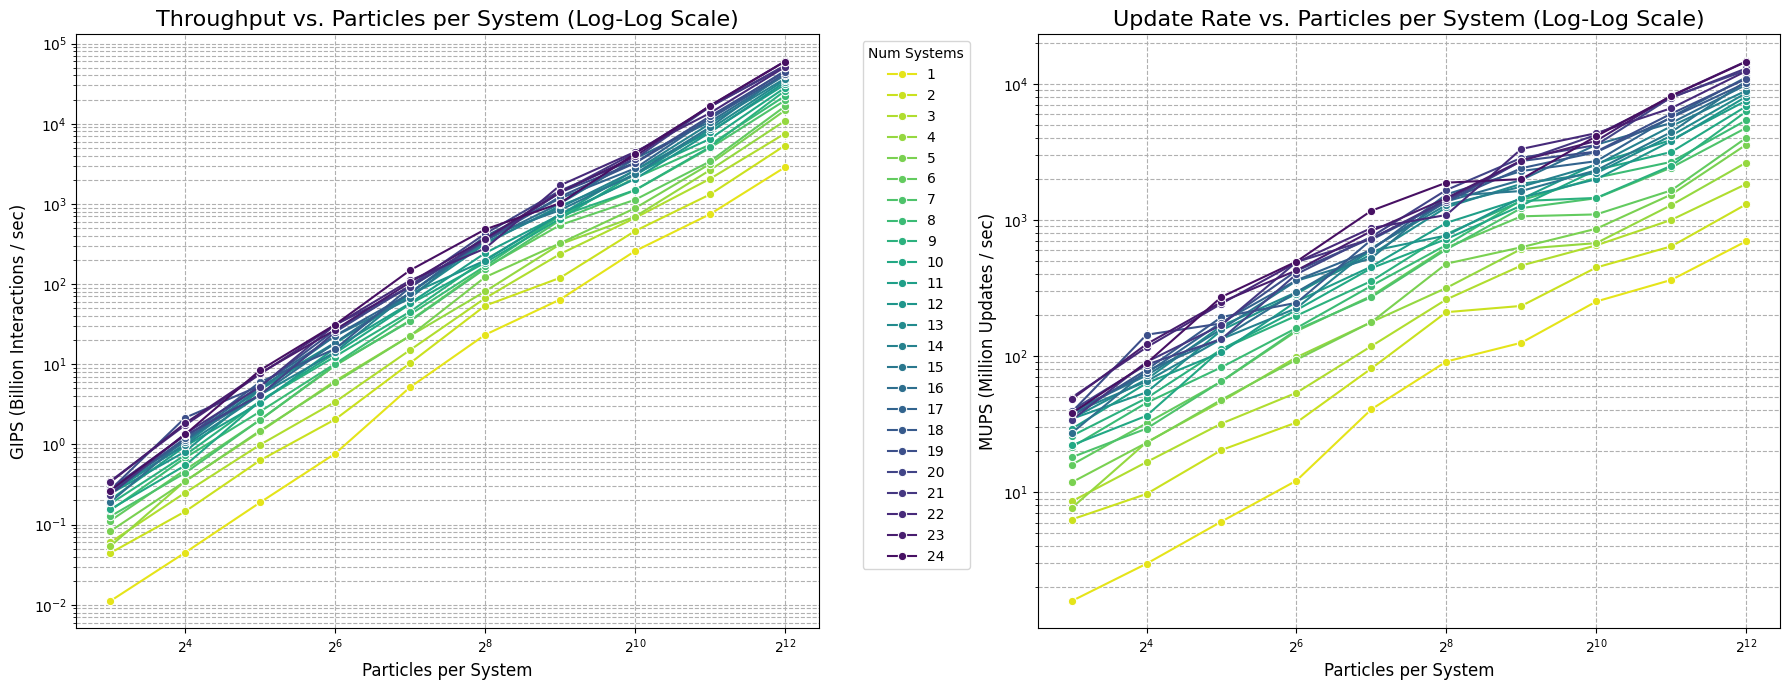

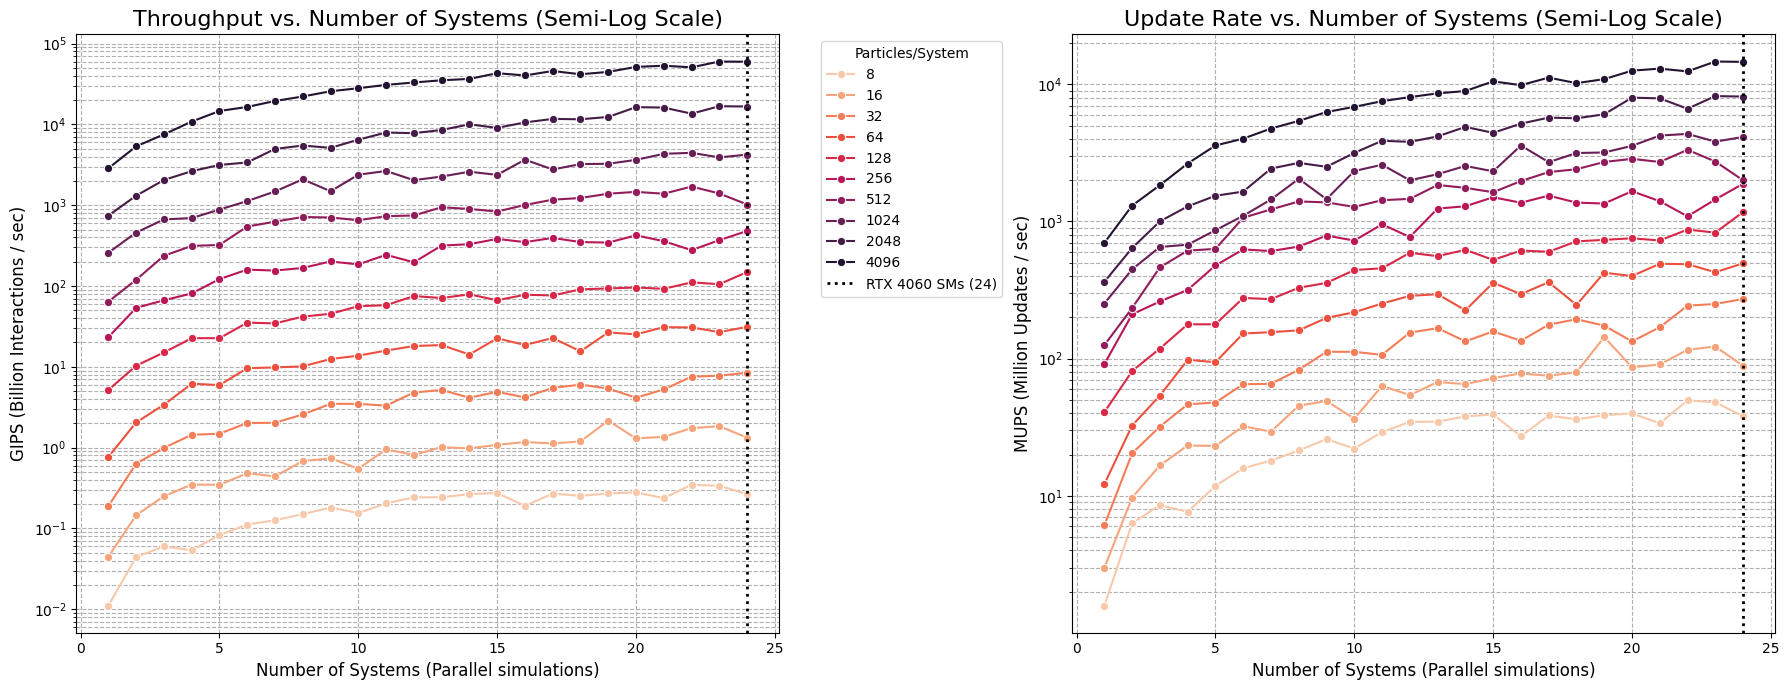

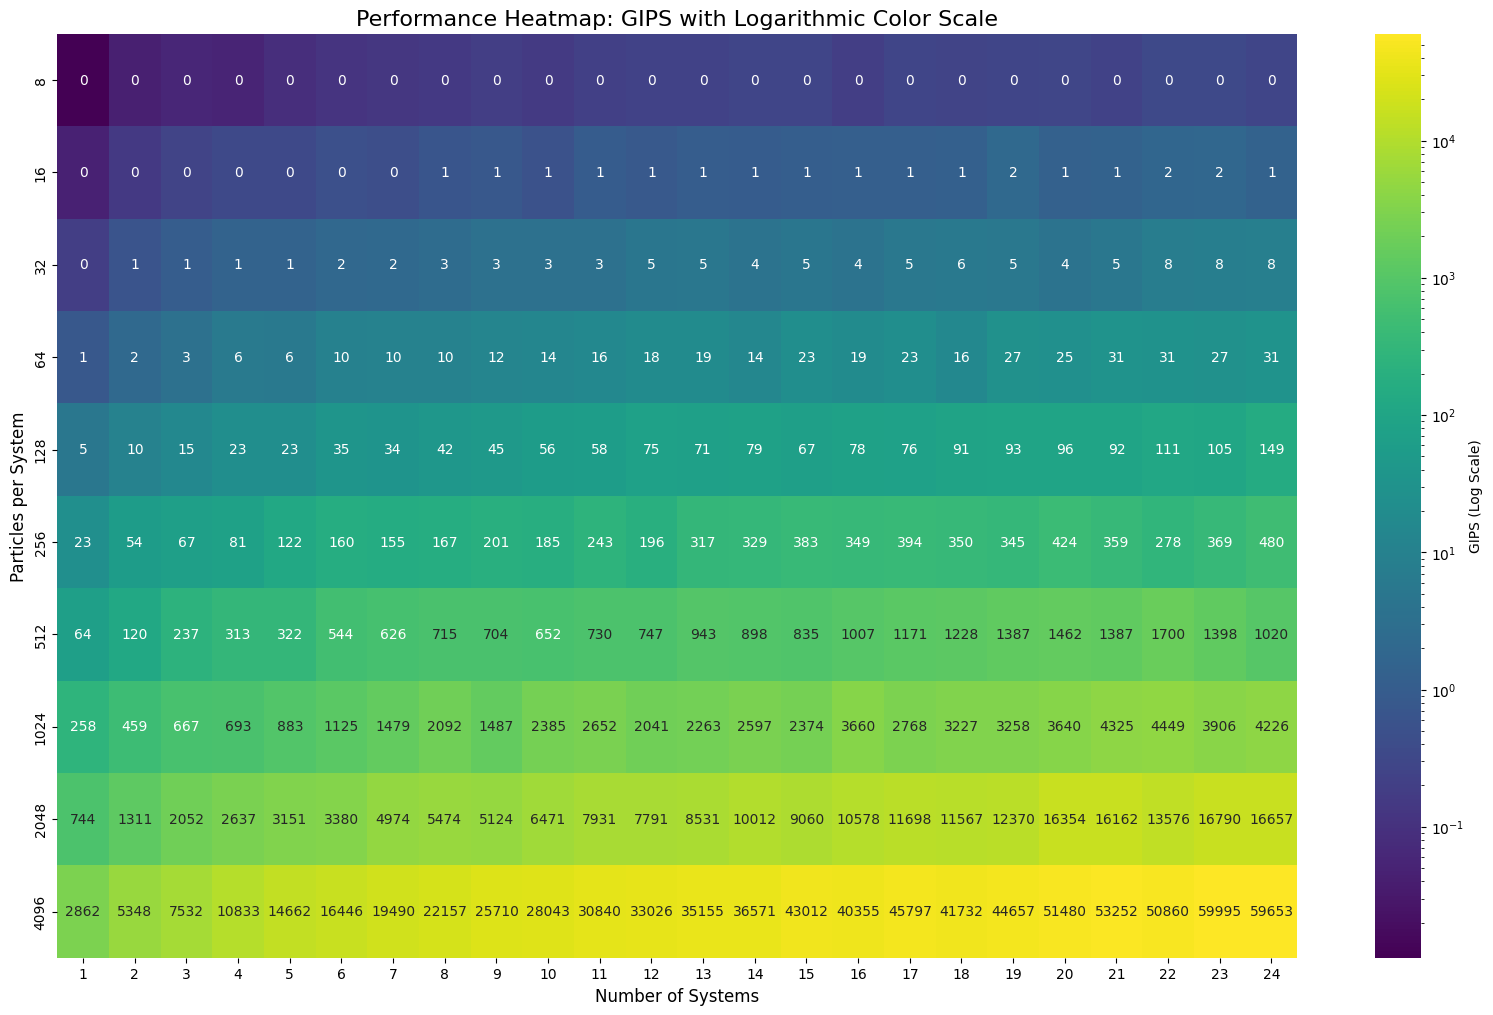

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import matplotlib.colors as colors # <-- Import the colors module

# --- Configuration ---
PERF_FILENAME = "perfs.csv"

# --- 1. Load and Pre-process the Data ---
if not os.path.exists(PERF_FILENAME):
    print(f"Error: Performance file '{PERF_FILENAME}' not found.")
else:
    df = pd.read_csv(PERF_FILENAME)
    
    # Group by unique configurations and average the results
    config_params = ['NumSystems', 'ParticlesPerSystem']
    perf_metrics = ['KernelTime_ms', 'GIPS', 'MUPS']
    df_avg = df.groupby(config_params)[perf_metrics].mean().reset_index()

    print("Successfully loaded and processed performance data.")

    # --- 2. Plotting ---

    # ==============================================================================
    # PLOT 1: Performance vs. Particles per System (Log-Log Plot)
    # ==============================================================================
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    palette = sns.color_palette("viridis_r", n_colors=df_avg['NumSystems'].nunique())

    # --- GIPS vs. Particles ---
    sns.lineplot(data=df_avg, x='ParticlesPerSystem', y='GIPS', hue='NumSystems', 
                 palette=palette, marker='o', ax=ax1)
    ax1.set_title('Throughput vs. Particles per System (Log-Log Scale)', fontsize=16)
    ax1.set_xlabel('Particles per System', fontsize=12)
    ax1.set_ylabel('GIPS (Billion Interactions / sec)', fontsize=12)
    ax1.set_xscale('log', base=2) # Use log base 2 for your sweep
    ax1.set_yscale('log') # Use log scale for performance
    ax1.grid(True, which="both", ls="--")
    ax1.legend(title='Num Systems', bbox_to_anchor=(1.05, 1), loc='upper left')

    # --- MUPS vs. Particles ---
    sns.lineplot(data=df_avg, x='ParticlesPerSystem', y='MUPS', hue='NumSystems', 
                 palette=palette, marker='o', ax=ax2)
    ax2.set_title('Update Rate vs. Particles per System (Log-Log Scale)', fontsize=16)
    ax2.set_xlabel('Particles per System', fontsize=12)
    ax2.set_ylabel('MUPS (Million Updates / sec)', fontsize=12)
    ax2.set_xscale('log', base=2)
    ax2.set_yscale('log')
    ax2.grid(True, which="both", ls="--")
    ax2.get_legend().remove()
    
    fig1.tight_layout()
    plt.show()


    # ==============================================================================
    # PLOT 2: Performance vs. Number of Systems (Semi-Log Plot)
    # ==============================================================================
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 7))
    palette2 = sns.color_palette("rocket_r", n_colors=df_avg['ParticlesPerSystem'].nunique())

    # --- GIPS vs. Systems ---
    sns.lineplot(data=df_avg, x='NumSystems', y='GIPS', hue='ParticlesPerSystem', 
                 palette=palette2, marker='o', ax=ax3)
    ax3.set_title('Throughput vs. Number of Systems (Semi-Log Scale)', fontsize=16)
    ax3.set_xlabel('Number of Systems (Parallel simulations)', fontsize=12)
    ax3.set_ylabel('GIPS (Billion Interactions / sec)', fontsize=12)
    ax3.set_yscale('log') # Use log scale for performance
    ax3.grid(True, which="both", ls="--")
    # Add a vertical line to mark the number of SMs
    ax3.axvline(24, color='k', linestyle=':', lw=2, label='RTX 4060 SMs (24)')
    ax3.legend(title='Particles/System', bbox_to_anchor=(1.05, 1), loc='upper left')

    # --- MUPS vs. Systems ---
    sns.lineplot(data=df_avg, x='NumSystems', y='MUPS', hue='ParticlesPerSystem', 
                 palette=palette2, marker='o', ax=ax4)
    ax4.set_title('Update Rate vs. Number of Systems (Semi-Log Scale)', fontsize=16)
    ax4.set_xlabel('Number of Systems (Parallel simulations)', fontsize=12)
    ax4.set_ylabel('MUPS (Million Updates / sec)', fontsize=12)
    ax4.set_yscale('log')
    ax4.grid(True, which="both", ls="--")
    ax4.axvline(24, color='k', linestyle=':', lw=2, label='RTX 4060 SMs (24)')
    ax4.get_legend().remove()

    fig2.tight_layout()
    plt.show()


    # ==============================================================================
    # PLOT 3: Heatmap with Logarithmic Color Scale
    # ==============================================================================
    pivot_gips = df_avg.pivot(index='ParticlesPerSystem', columns='NumSystems', values='GIPS')

    fig3, ax5 = plt.subplots(1, 1, figsize=(20, 12))
    
    # Use LogNorm to map the color scale logarithmically
    sns.heatmap(pivot_gips, 
                annot=True,               # Annotate cells with values
                fmt=".0f",                # Format annotations as integers (better for log scale)
                cmap="viridis",           # Color map
                ax=ax5, 
                norm=colors.LogNorm(),    # <-- THIS IS THE KEY CHANGE
                cbar_kws={'label': 'GIPS (Log Scale)'})
    
    ax5.set_title('Performance Heatmap: GIPS with Logarithmic Color Scale', fontsize=16)
    ax5.set_xlabel('Number of Systems', fontsize=12)
    ax5.set_ylabel('Particles per System', fontsize=12)
    plt.show()

In [16]:
# Use this magic command for an interactive 3D plot you can rotate
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <-- Essential for 3D plotting
import numpy as np
import os

# --- Configuration ---
PERF_FILENAME = "perfs.csv"

# --- 1. Load and Pre-process the Data ---
if not os.path.exists(PERF_FILENAME):
    print(f"Error: Performance file '{PERF_FILENAME}' not found.")
else:
    df = pd.read_csv(PERF_FILENAME)
    
    # Group by unique configurations and average the results
    config_params = ['NumSystems', 'ParticlesPerSystem']
    perf_metrics = ['GIPS', 'MUPS'] # We'll plot GIPS
    df_avg = df.groupby(config_params)[perf_metrics].mean().reset_index()

    print("Successfully loaded and processed performance data.")

    # --- 2. Prepare Data for a 3D Surface ---
    # A surface plot requires a 2D grid of X, Y, and Z coordinates.
    
    # a) Get the unique values for our X and Y axes
    x_vals = df_avg['NumSystems'].unique()
    y_vals = df_avg['ParticlesPerSystem'].unique()
    
    # b) Create a 2D grid (a "meshgrid") from these unique values.
    #    X and Y will be 2D arrays representing the coordinates of every point on the grid.
    X, Y = np.meshgrid(x_vals, y_vals)
    
    # c) Pivot the DataFrame to get the Z values (GIPS) in the same 2D grid format.
    #    We need to fill missing values with 0 or NaN if the sweep was incomplete.
    Z = df_avg.pivot(index='ParticlesPerSystem', columns='NumSystems', values='GIPS').fillna(0)

    # --- Create the STATIC 3D Surface Plot ---
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='black', linewidth=0.1)

    # --- KEY CHANGE: Manually set the camera angle ---
    # elev = elevation angle (up/down), azim = azimuthal angle (left/right)
    ax.view_init(elev=30, azim=45) 

    ax.set_title('Performance Landscape: GIPS vs. System Parameters (Static View)', fontsize=16, pad=20)
    ax.set_xlabel('Number of Systems', fontsize=12, labelpad=10)
    ax.set_ylabel('Particles per System', fontsize=12, labelpad=10)
    ax.set_zlabel('GIPS (Billion Interactions / sec)', fontsize=12, labelpad=10)
    # ax.set_ylim(bottom=Y.min())
    # ax.set_yscale('log', base=2)
    fig.colorbar(surf, shrink=0.5, aspect=10, label='GIPS')

    plt.show()

    fig.show()

Successfully loaded and processed performance data.


<IPython.core.display.Javascript object>